In [1]:
import os
import time
import pandas as pd
import h2o 
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 42
TRAIN_TIME_SECS = 600
MAX_MODELS = 20
N_THREADS = -1

MODEL_DRIVEN_SYNTHETIC_PATH = "../data/02_processed/model_driven_synthetic.csv"
IMBALANCED_DATA_PATH = "../data/01_raw/original_imbalanced.csv"

# --- Previous Results (for comparison) ---


In [3]:
results = {
    'Balanced': {'auc': 0.9720, 'auprc': 0.9630, 'f1': 0.9581, 'recall': 1.0, 'precision': 0.9740, 'accuracy': 0.9575},
    'Imbalanced': {'auc': 0.9692, 'auprc': 0.7405, 'f1': 0.8049, 'recall': 1.0, 'precision': 1.000, 'accuracy': 0.9664},
    'SMOTE': {'auc': 0.9706, 'auprc': 0.7344, 'f1': 0.8030, 'recall': 1.0, 'precision': 1.000, 'accuracy': 0.9657}
}

In [4]:
h2o.init(nthreads=N_THREADS, max_mem_size="10g")

# Load data
print("Loading model driven synthetic training data...")
df_train_md = pd.read_csv(MODEL_DRIVEN_SYNTHETIC_PATH)
hf_train_md = h2o.H2OFrame(df_train_md)
response = "target"
predictors = [c for c in hf_train_md.columns if c != response]
hf_train_md[response] = hf_train_md[response].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-17.0.16+8 (build 17.0.16+8, mixed mode, sharing)
  Starting server from C:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\bharg\AppData\Local\Temp\tmpbiu838g9
  JVM stdout: C:\Users\bharg\AppData\Local\Temp\tmpbiu838g9\h2o_bharg_started_from_python.out
  JVM stderr: C:\Users\bharg\AppData\Local\Temp\tmpbiu838g9\h2o_bharg_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 6 days
H2O_cluster_name:,H2O_from_python_bharg_rf9c2r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Loading model driven synthetic training data...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
print("Loading original imbalanced data to extract the consistent test set...")
df_imbalanced = pd.read_csv(IMBALANCED_DATA_PATH)
hf_imbalanced = h2o.H2OFrame(df_imbalanced)
hf_imbalanced[response] = hf_imbalanced[response].asfactor()
_, _, test_hf = hf_imbalanced.split_frame(ratios=[0.7, 0.15], seed=RANDOM_STATE)

print(f"Training data shape: {hf_train_md.shape}")
print(f"Test data shape: {test_hf.shape}")

Loading original imbalanced data to extract the consistent test set...


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training data shape: (294727, 41)
Test data shape: (10500, 41)


In [6]:
print("Training AutoML on the model driven synthetic dataset...")
aml_md = H2OAutoML(
    max_runtime_secs=TRAIN_TIME_SECS,
    max_models=MAX_MODELS,
    seed=RANDOM_STATE,
    project_name=f"model_driven_eval_{int(time.time())}",
    sort_metric="AUCPR"
)

aml_md.train(x=predictors, y=response, training_frame=hf_train_md)

print("\n Evaluating Best Model on Original Imbalanced Test set")
lb_md = aml_md.leaderboard
print(lb_md.head(rows=lb_md.nrows))

performance_md = aml_md.leader.model_performance(test_hf)
print(performance_md)

# Store results
results['ModelDriven'] = {
    'auc': performance_md.auc(), 
    'auprc': performance_md.pr_auc(), 
    'f1': performance_md.F1()[0][1],
    'recall': performance_md.recall()[0][1], 
    'precision': performance_md.precision()[0][1],
    'accuracy': performance_md.accuracy()[0][1]
}


Training AutoML on the model driven synthetic dataset...
AutoML progress: |
01:03:36.682: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

 Evaluating Best Model on Original Imbalanced Test set
model_id                                       aucpr       auc    logloss    mean_per_class_error       rmse         mse
GBM_1_AutoML_1_20250903_10336               0.999261  0.997266  0.0233734               0.0117488  0.069143   0.00478075
GBM_4_AutoML_1_20250903_10336               0.999161  0.996955  0.0245947               0.012138   0.0715205  0.00511518
GBM_3_AutoML_1_20250903_10336               0.999042  0.996687  0.0229774               0.0112645  0.0681919  0.00465014
GBM_grid_1_AutoML_1_20250903_10336_model_2  0.999012  0.99648   0.0267032               0.0137132  0.0762236  0.00581003
DRF_1_AutoML_1_20250903_10336               0.998954  0.996432  0.0615342               0.0191069  0.112219   0.0125931
GBM_

C:\Users\bharg\AppData\Local\Temp\ipykernel_3636\1047632275.py:22: H2ODeprecationWarning: ``MetricsBase.pr_auc`` is deprecated, please use ``MetricsBase.aucpr`` instead.
  'auprc': performance_md.pr_auc(),




 FINAL PERFORMANCE COMPARISON
                auc   auprc      f1  recall  precision  accuracy
Balanced     0.9720  0.9630  0.9581     1.0     0.9740    0.9575
Imbalanced   0.9692  0.7405  0.8049     1.0     1.0000    0.9664
SMOTE        0.9706  0.7344  0.8030     1.0     1.0000    0.9657
ModelDriven  0.9642  0.7181  0.7695     1.0     0.7878    0.9623


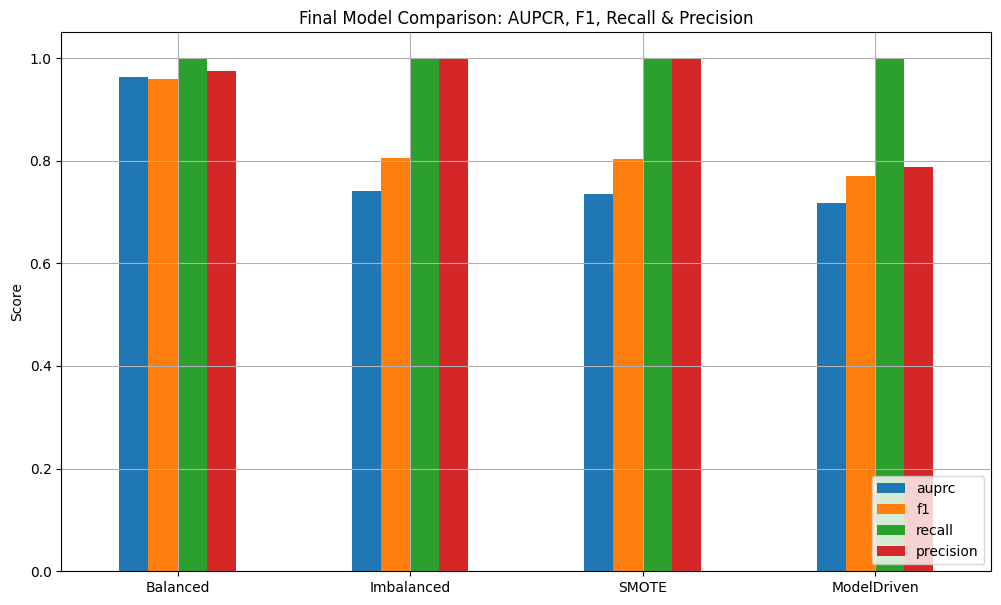

H2O session _sid_9939 closed.


In [7]:
# Final comparison
df_results = pd.DataFrame(results).T.round(4)

print("\n\n FINAL PERFORMANCE COMPARISON")
print(df_results)

df_results[['auprc', 'f1', 'recall', 'precision']].plot(
    kind="bar",
    figsize=(12, 7),
    grid=True,
    title="Final Model Comparison: AUPCR, F1, Recall & Precision"
)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

h2o.cluster().shutdown()